## Gather

In [340]:
import tweepy
import pprint
import pandas as pd
import numpy as np
import requests
import json
import time
from numpy import nan
import re
from datetime import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'figsize', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [356]:
df = pd.read_csv('twitter-archive-enhanced.csv')
image_pred_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True,wait_on_rate_limit_notify =True)

In [357]:
tweet_dict_list = []

for tweet_id in df['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode = 'extended')
        entry = {'tweet_id':tweet.id, 'retweet_count':tweet.retweet_count,'favorite_count':tweet.favorite_count}
        tweet_dict_list.append(entry)
    except tweepy.error.TweepError, e:
        if 'Rate limit' not in e.message:
            print e.message
        else:
            print e.message
        continue

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
  if __name__ == '__main__':
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
  # Remove the CWD from sys.path while we load stuff.


[{u'message': u'No status found with that ID.', u'code': 144}]
[{u'message': u'No status found with that ID.', u'code': 144}]
[{u'message': u'No status found with that ID.', u'code': 144}]
[{u'message': u'No status found with that ID.', u'code': 144}]
[{u'message': u'No status found with that ID.', u'code': 144}]
Rate limit reached. Sleeping for: 674
Rate limit reached. Sleeping for: 677


In [371]:
with open('tweet_data.txt', 'w') as outfile:
    json.dump(tweet_dict_list,outfile)

In [374]:
tweet_df = pd.DataFrame(tweet_dict_list)

In [376]:
cols = tweet_df.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [377]:
tweet_df = tweet_df[cols]

In [380]:
tweet_df.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39431,8818
1,892177421306343426,33742,6464
2,891815181378084864,25411,4283
3,891689557279858688,42795,8897
4,891327558926688256,40934,9689


In [378]:
tweet_df_clean = tweet_df.copy()
df_clean = df.copy()
image_pred_df_clean = image_pred_df.copy()

## Assess

* tweet_df = my own tweepy database
* df = the enhanced twitter archive
* image_pred_df

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

* Tweet_id is a float, need to change to int
* Timestamp needs to be changed to a datetime object
* Change all None to NaN or vise-verse

In [245]:
tweet_df.head()

,favorite_count,tweet_id,retweet_count
0,2524,666020888022790149,529


* Need to remove the retweeted_status_id and the retweeted_status_user_ids because they don't have expanded_urls
* Possible numerator and denominator mix up?

In [246]:
df['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
the            8
Sadie          8
Daisy          7
Toby           7
Bailey         7
Buddy          7
an             7
Stanley        6
Koda           6
Scout          6
Jax            6
Dave           6
Leo            6
Bella          6
Jack           6
Milo           6
Rusty          6
Oscar          6
Gus            5
            ... 
Tove           1
Glacier        1
Pip            1
Zoe            1
Cilantro       1
Jennifur       1
Olaf           1
Teddy          1
Socks          1
Snoop          1
Lenox          1
Jeremy         1
Zooey          1
Todo           1
Kanu           1
Ember          1
Steve          1
Laika          1
Eazy           1
Obi            1
Kane           1
Finnegus       1
Alexander      1
Meatball       1
Zara           1
Bronte         1
Edgar          1
Glenn         

* 55 dogs named "a", 765 dogs named "None", 7 dogs names "the", 7 dogs named "an"
* Many mispelled names


In [247]:
df.text.head()

0                                            This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...
2        This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...
Name: text, dtype: object

* Locate and change wrong names through text if possible

In [248]:
df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

* replace the complicated text with easier text

In [249]:
for col in df.columns.values:
    print "num dup " + col + ": " + str(len(df[df[col].duplicated()]))

num dup tweet_id: 0
num dup in_reply_to_status_id: 2278
num dup in_reply_to_user_id: 2324
num dup timestamp: 0
num dup source: 2352
num dup text: 0
num dup retweeted_status_id: 2174
num dup retweeted_status_user_id: 2330
num dup retweeted_status_timestamp: 2174
num dup expanded_urls: 137
num dup rating_numerator: 2316
num dup rating_denominator: 2338
num dup name: 1399
num dup doggo: 2354
num dup floofer: 2354
num dup pupper: 2354
num dup puppo: 2354


* expanded_urls duplicates numbered at 137
* high number of duplicates: probably None values

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [251]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [252]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


In [253]:
image_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Quality Issues

* Tweet_id is a float, need to change to categorical (check)
* Timestamp needs to be changed to a datetime object (check)
* Change all None to NaN or vise-verse (check)
* 55 dogs named "a", 765 dogs named "None", 7 dogs names "the", 7 dogs named "an" (doing)
* Many mispelled names (doing)
* Locate and change wrong names through text if possible 
* Need to remove the retweeted_status_id and the retweeted_status_user_ids because they don't have expanded_urls (check)
* Remove the rating, and webpage from text (check)
* Source only needs to include the source (check)
* remove the data where expanded URLs is None
* Display only the source not the full html


### Tidiness

 * if hashtag, instagram exists, put it into a new column named hashtags (check)
* Join the ratings together as numerator and denominator
* Remove the numerator and the denominator columns


## Wrangle

### Quality

* Tweet_id is a float, need to change to categorical

#### Define

* Using as_type(category) change all the df['tweet_id'] to category

#### Code

In [254]:
df['tweet_id'] = df['tweet_id'].astype('category')

#### Test

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null category
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: category(1), float64(

* Timestamp needs to be changed to a datetime object and remove the fleeting '+0000's

#### Define

* String slice the last 6 characters off of the timestamp
* apply datetime.striptime to change datetime into a datetime object

#### Code

In [256]:
df['timestamp'] = df['timestamp'].str[:-6]

In [343]:
df.timestamp.head()

tweet_id
892420643555336193    2017-08-01 16:23:56
892177421306343426    2017-08-01 00:17:27
891815181378084864    2017-07-31 00:18:03
891689557279858688    2017-07-30 15:58:51
891327558926688256    2017-07-29 16:00:24
Name: timestamp, dtype: object

In [344]:
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

#### Test

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null category
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: category(1), float64(

In [259]:
df['timestamp'].head()

0    2017-08-01 16:23:56
1    2017-08-01 00:17:27
2    2017-07-31 00:18:03
3    2017-07-30 15:58:51
4    2017-07-29 16:00:24
Name: timestamp, dtype: object

* Change all None to NaN, in order to see how many missing values there are through .info()

#### Define

* dataframe.replace to replace all string "None" to Nonetype


#### Code

In [260]:
df.replace({"None":None},inplace=True)

In [261]:
df = df.where((pd.notnull(df)),None)

#### Test

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null category
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1611 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dtypes: category(1), int64(2), object(14

* Locate and change wrong names through text if possible

#### Define

* Using a regular expression, find words after the words: Named, Name, Name is, This is, and compare to name

#### Code

In [263]:
df['possible_names'] = df.text.str.extract('(?:MEET|THIS IS|HELLO TO|HERE IS|NAME IS|NAMED)\s(\w+)\.?', flags = re.I|re.M)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [264]:
df['name'] == df['possible_names']

0        True
1        True
2        True
3        True
4        True
5       False
6        True
7       False
8        True
9        True
10       True
11       True
12      False
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24      False
25      False
26       True
27       True
28       True
29       True
        ...  
2326     True
2327     True
2328    False
2329    False
2330    False
2331    False
2332    False
2333     True
2334     True
2335     True
2336    False
2337    False
2338    False
2339    False
2340    False
2341    False
2342    False
2343    False
2344    False
2345     True
2346     True
2347     True
2348     True
2349     True
2350     True
2351    False
2352     True
2353     True
2354     True
2355    False
Length: 2356, dtype: bool

In [267]:
df = df.where((pd.notnull(df)),None)

In [268]:
possible_bad_names_df = df.loc[df.name != df.possible_names]

In [269]:
len(possible_bad_names_df)

755

In [270]:
possible_bad_names_df.head(n=20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,possible_names
5,891087950875897856,None,None,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https:/...,None,None,None,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None,None
7,890729181411237888,None,None,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,None,None,None,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None,None
12,889665388333682689,None,None,2017-07-25 01:55:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,None,None,None,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo,None
24,887343217045368832,None,None,2017-07-18 16:08:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,None,None,None,https://twitter.com/dog_rates/status/887343217045368832/video/1,13,10,None,None,None,None,None,None
25,887101392804085760,None,None,2017-07-18 00:07:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad...,None,None,None,https://twitter.com/dog_rates/status/887101392804085760/photo/1,12,10,None,None,None,None,None,None
30,886267009285017600,8.86266e+17,2.28118e+09,2017-07-15 16:51:35,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,None,None,None,None,12,10,None,None,None,None,None,None
32,886054160059072513,None,None,2017-07-15 02:45:48,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.86054e+17,1.96074e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None,None
35,885518971528720385,None,None,2017-07-13 15:19:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None,None,None,https://twitter.com/4bonds2carbon/status/885517367337512960,14,10,None,None,None,None,None,Howard
37,885167619883638784,None,None,2017-07-12 16:03:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.c...,None,None,None,"https://twitter.com/dog_rates/status/885167619883638784/photo/1,https://twitter.com/dog_rates/status/885167619883638784/photo/1,https://twitter.co...",13,10,None,None,None,None,None,None
41,884441805382717440,None,None,2017-07-10 15:58:53,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I present to you, Pup in Hat. Pup in Hat is great for 

In [271]:
possible_bad_names_df.possible_names.value_counts()

a             8
Olivi         2
Bretagne      2
SO            2
Tickles       2
Fl            2
Blue          2
getting       2
dog           2
ALL           1
Yoshi         1
Sabertooth    1
all           1
Howard        1
doing         1
Ralph         1
AMAZING       1
fabulous      1
what          1
no            1
Zeus          1
Big           1
Charley       1
Thea          1
actually      1
Zoey          1
Am            1
G             1
CHARLIE       1
Dev           1
Fr            1
Guss          1
Name: possible_names, dtype: int64

In [272]:
possible_bad_names_df.loc[possible_bad_names_df.possible_names == "Olivi"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,possible_names
1465,694352839993344000,None,None,2016-02-02 02:53:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,None,None,None,"https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.co...",10,10,Oliviér,None,None,None,None,Olivi
2164,669371483794317312,None,None,2015-11-25 04:26:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Oliviér. He's a Baptist Hindquarter. Also smooth af with the babes. 10/10 I'd totally get in a car with him https://t.co/fj4c170cxk,None,None,None,https://twitter.com/dog_rates/status/669371483794317312/photo/1,10,10,Oliviér,None,None,None,None,Olivi


In [273]:
null_names_df = possible_bad_names_df.loc[possible_bad_names_df.name.isnull()]

In [274]:
for name in null_names_df['possible_names'].unique():
    print name

None
Howard
doing
no
Zoey
CHARLIE
AMAZING
Blue
ALL
actually
SO
Tickles
Bretagne
a
Charley
all
what
dog
getting
Thea
Sabertooth
Yoshi
fabulous
Zeus
Guss
Big


In [275]:
null_names_df.loc[~null_names_df['possible_names'].isnull()].text.head(n=20)

35                                                                                   I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk
101             RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. htt…
164    Here we have perhaps the wisest dog of all. Above average with light sabers. Immortal as h*ck. 14/10 dog, or dog not, there is no try https://t.co...
168    Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t...
184                 THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA
190                                        HE'S LIKE "WAIT A MINUTE I'M AN ANIMAL THIS IS AMAZING HI HUMAN I LOVE YOU AS WELL" 13/10 https://t.co/sb73bV5Y7S
204           RT @dog_rates: I usually only share these on

In [276]:
pd.options.display.max_colwidth = 150

In [277]:
for x in range(30):
    print "\n"
    print possible_bad_names_df.text



5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https:/...
7              When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12                         Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24                                           You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25      This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad...
30                                                  @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
32                                                

In [278]:
possible_bad_names_df.loc

In [279]:
list_of_possible_names = possible_bad_names_df[(possible_bad_names_df['possible_names'].notnull())].possible_names.unique()
list_of_possible_names

array(['Howard', 'doing', 'no', 'Zoey', 'CHARLIE', 'AMAZING', 'Blue',
       'ALL', 'actually', 'SO', 'Tickles', 'Bretagne', 'getting', 'a',
       'Charley', 'all', 'Dev', 'what', 'dog', 'Ralph', 'Fl', 'Olivi',
       'Fr', 'Thea', 'Sabertooth', 'Yoshi', 'fabulous', 'Zeus', 'Am', 'G',
       'Guss', 'Big'], dtype=object)

In [280]:
list_of_possible_names = ['Howard','Zoey', 'CHARLIE','Blue','Tickles', 'Bretagne','Thea','Sabertooth','Yoshi','Zeus','Gus']

In [281]:
name_change_df = possible_bad_names_df.loc[possible_bad_names_df.possible_names.isin(list_of_possible_names)]

In [282]:
name_change_df['name'] = possible_bad_names_df.possible_names

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [283]:
name_change_df = name_change_df.drop('possible_names', axis = 1)

In [284]:
name_change_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
35,885518971528720385,None,None,2017-07-13 15:19:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None,None,None,https://twitter.com/4bonds2carbon/status/885517367337512960,14,10,Howard,None,None,None,None
168,859607811541651456,None,None,2017-05-03 03:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t...,None,None,None,https://twitter.com/dog_rates/status/859607811541651456/photo/1,13,10,Zoey,None,None,None,puppo
184,856526610513747968,8.55818e+17,4.19698e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",None,None,None,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,CHARLIE,None,None,None,None
204,852936405516943360,None,None,2017-04-14 17:27:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t…",8.3165e+17,4.19698e+09,2017-02-14 23:43:18 +0000,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831...",13,10,Blue,None,None,None,None
349,831650051525054464,None,None,2017-02-14 23:43:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https...",None,None,None,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831...",13,10,Blue,None,None,None,None
603,798628517273620480,None,None,2016-11-15 20:47:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,6.67509e+17,4.19698e+09,2015-11-20 01:06:48 +0000,"https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://twitter.com/dog_rates/status/667509364010450944/photo/1",12,10,Tickles,None,None,None,None
784,775096608509886464,None,None,2016-09-11 22:20:06,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.40373e+17,4.19698e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.co...",9,11,Bretagne,None,None,None,None
1068,740373189193256964,None,None,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",None,None,None,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.co...",9,11,Bretagne,None,None,None,None
1678,682047327939461121,None,None,2015-12-30 03:55:29,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iP

In [285]:
df.set_index('tweet_id',inplace = True)
name_change_df.set_index('tweet_id', inplace = True)
df.update(name_change_df)

In [286]:
df.loc[df.name.isin(list_of_possible_names)]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,possible_names
tweet_id,,,,,,,,,,,,,,,,,
890609185150312448,None,None,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,None,None,None,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13.0,10.0,Zoey,None,None,None,None,Zoey
885518971528720385,None,None,2017-07-13 15:19:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None,None,None,https://twitter.com/4bonds2carbon/status/885517367337512960,14.0,10.0,Howard,None,None,None,None,Howard
882762694511734784,None,None,2017-07-06 00:46:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl https://t.co/D43I96SlVu,None,None,None,https://twitter.com/dog_rates/status/882762694511734784/photo/1,12.0,10.0,Gus,None,None,pupper,None,Gus
870374049280663552,None,None,2017-06-01 20:18:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https:...,None,None,None,https://twitter.com/dog_rates/status/870374049280663552/photo/1,13.0,10.0,Zoey,None,None,None,None,Zoey
859607811541651456,None,None,2017-05-03 03:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t...,None,None,None,https://twitter.com/dog_rates/status/859607811541651456/photo/1,13.0,10.0,Zoey,None,None,None,puppo,Zoey
856526610513747968,8.55818e+17,4.19698e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",None,None,None,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14.0,10.0,CHARLIE,None,None,None,None,CHARLIE
852936405516943360,None,None,2017-04-14 17:27:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t…",8.3165e+17,4.19698e+09,2017-02-14 23:43:18 +0000,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831...",13.0,10.0,Blue,None,None,None,None,Blue
831650051525054464,None,None,2017-02-14 23:43:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https...",None,None,None,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831...",13.0,10.0,Blue,None,None,None,None,Blue
828801551087042563,None,None,2017-02-07 03:04:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Gus. He likes to be close to you, which is good because you want to be close to Gus. 12/10 would boop then pet https…",8.10254e+17,4.19698e+09,2016-12-17 22:43:27 +0000,https://twitter.com/dog_rate

In [287]:
df = df.drop('possible_names',axis=1)

#### Test

In [288]:
df.loc[df.name.isin(list_of_possible_names)]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
890609185150312448,None,None,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,None,None,None,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13.0,10.0,Zoey,None,None,None,None
885518971528720385,None,None,2017-07-13 15:19:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None,None,None,https://twitter.com/4bonds2carbon/status/885517367337512960,14.0,10.0,Howard,None,None,None,None
882762694511734784,None,None,2017-07-06 00:46:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl https://t.co/D43I96SlVu,None,None,None,https://twitter.com/dog_rates/status/882762694511734784/photo/1,12.0,10.0,Gus,None,None,pupper,None
870374049280663552,None,None,2017-06-01 20:18:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https:...,None,None,None,https://twitter.com/dog_rates/status/870374049280663552/photo/1,13.0,10.0,Zoey,None,None,None,None
859607811541651456,None,None,2017-05-03 03:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t...,None,None,None,https://twitter.com/dog_rates/status/859607811541651456/photo/1,13.0,10.0,Zoey,None,None,None,puppo
856526610513747968,8.55818e+17,4.19698e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",None,None,None,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14.0,10.0,CHARLIE,None,None,None,None
852936405516943360,None,None,2017-04-14 17:27:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t…",8.3165e+17,4.19698e+09,2017-02-14 23:43:18 +0000,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831...",13.0,10.0,Blue,None,None,None,None
831650051525054464,None,None,2017-02-14 23:43:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10\n\nhttps://t.co/piiX0ke8Z6 https...",None,None,None,"http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525054464/photo/1,https://twitter.com/dog_rates/status/831...",13.0,10.0,Blue,None,None,None,None
828801551087042563,None,None,2017-02-07 03:04:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Gus. He likes to be close to you, which is good because you want to be close to Gus. 12/10 would boop then pet https…",8.10254e+17,4.19698e+09,2016-12-17 22:43:27 +0000,https://twitter.com/dog_rates/status/810254108431155201/photo/1,12.0,10.0,Gus,None,None,

* Many mispelled names

#### Define

* visually look through values to change mispelled names

#### Code

In [289]:
bad_names = []

for word in df['name']:
    if word != None:
        if word[0].isupper() == False:
            bad_names.append(word)

In [290]:
bad_names = set(bad_names)

In [291]:
bad_names

{'a',
 'actually',
 'all',
 'an',
 'by',
 'getting',
 'his',
 'incredibly',
 'infuriating',
 'just',
 'life',
 'light',
 'mad',
 'my',
 'not',
 'officially',
 'old',
 'one',
 'quite',
 'space',
 'such',
 'the',
 'this',
 'unacceptable',
 'very'}

In [292]:
df['name'].value_counts()
d = {bad_name:None for bad_name in bad_names}
d['CHARLIE']="Charlie"

df['name'].replace(d,inplace=True)

#### Test

In [293]:
df.name.value_counts()

Charlie      13
Cooper       11
Oliver       11
Lucy         11
Lola         10
Tucker       10
Penny        10
Bo            9
Winston       9
Sadie         8
Bailey        7
Buddy         7
Toby          7
Daisy         7
Rusty         6
Leo           6
Jax           6
Dave          6
Scout         6
Milo          6
Bella         6
Jack          6
Stanley       6
Oscar         6
Koda          6
Phil          5
Finn          5
Chester       5
Alfie         5
Gus           5
             ..
Creg          1
Maisey        1
Kollin        1
Dotsy         1
Tove          1
Glacier       1
Obi           1
Ester         1
Glenn         1
Edgar         1
Mollie        1
Teddy         1
Snoop         1
Lenox         1
Jeremy        1
Zooey         1
Todo          1
Kanu          1
Ember         1
Steve         1
Laika         1
Socks         1
Eazy          1
Kane          1
Finnegus      1
Alexander     1
Meatball      1
Zara          1
Bronte        1
Opie          1
Name: name, Length: 937,

* make a separate column for the ratings and the hashtags

#### Define

* Use regex to grab the ratings and from the text and remove the url and rating from the text

#### Code

In [311]:
df['ratings'] = df.text.str.extract(r'(\d{1,4}[/b]{1}\d{1,4})', expand =True)
df['text'] = df['text'].str.replace('http\S+|www.\S+', '',flags=re.I)
df['text'] = df.text.str.replace(r'(\s*\d{1,4}[/b]{1}\d{1,4})','')
df['hashtags'] = df.text.str.findall(r'#.*?(?=\.?\s|$)')

#### Test

In [312]:
df.hashtags.head()

tweet_id
892420643555336193             []
892177421306343426             []
891815181378084864             []
891689557279858688             []
891327558926688256    [#BarkWeek]
Name: hashtags, dtype: object

In [313]:
df.ratings.head(n=5)

tweet_id
892420643555336193    NaN
892177421306343426    NaN
891815181378084864    NaN
891689557279858688    NaN
891327558926688256    NaN
Name: ratings, dtype: object

In [315]:
df[df['hashtags'].map(len) >=1].hashtags

tweet_id
891327558926688256                        [#BarkWeek]
891087950875897856                        [#BarkWeek]
890609185150312448                        [#BarkWeek]
890006608113172480                        [#BarkWeek]
889531135344209921                        [#BarkWeek]
889278841981685760                        [#BarkWeek]
886054160059072513                            [#BATP]
881268444196462592                       [#Canada150]
878776093423087618    [#PrideMonthPuppo, #PrideMonth]
874012996292530176                      [#PrideMonth]
872820683541237760           [#dogsatpollingstations]
872620804844003328                      [#PrideMonth]
871879754684805121                      [#PrideMonth]
855851453814013952                    [#ScienceMarch]
841439858740625411                   [#K9VeteransDay]
838916489579200512                        [#GoodDogs]
831315979191906304                      [#WKCDogShow]
824325613288833024                    [#BellLetsTalk]
822872901745569793 

* Remove the rating, and webpage from text

* Remove expanded_urls that are null

#### Define

* Remove by locating them and nullifying them with loc[~..

#### Code

In [316]:
df = df.loc[~df['expanded_urls'].isnull()]

#### Test

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 2297 entries, 892420643555336193 to 666020888022790149
Data columns (total 18 columns):
in_reply_to_status_id         23 non-null object
in_reply_to_user_id           23 non-null object
timestamp                     2297 non-null object
source                        2297 non-null object
text                          2297 non-null object
retweeted_status_id           180 non-null object
retweeted_status_user_id      180 non-null object
retweeted_status_timestamp    180 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2297 non-null float64
rating_denominator            2297 non-null float64
name                          1515 non-null object
doggo                         94 non-null object
floofer                       10 non-null object
pupper                        255 non-null object
puppo                         29 non-null object
ratings                       0 non-null object
hash

* Source only needs to include the source not the html

#### Define

* take out the everything but "Vine - Make a Scene", 'Twitter for iPhone', "Twitter Web Client", "TweetDeck"


#### Code

In [318]:
source_names = ["Vine - Make a Scene", 'Twitter for iPhone', "Twitter Web Client", "TweetDeck"]

for word in source_names:
    df.loc[df.source.str.contains(word), 'source'] = word

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Test

In [319]:
df.source.value_counts()

Twitter for iPhone     2163
Vine - Make a Scene      91
Twitter Web Client       32
TweetDeck                11
Name: source, dtype: int64

* Need to remove the retweeted_status_id and the retweeted_status_user_ids because they don't have expanded_urls

#### Define

* only use data from the NaN in_reply_to_status

#### Code

In [320]:
df = df.loc[df['in_reply_to_status_id'].isnull()] 

#### Test

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 2274 entries, 892420643555336193 to 666020888022790149
Data columns (total 18 columns):
in_reply_to_status_id         0 non-null object
in_reply_to_user_id           0 non-null object
timestamp                     2274 non-null object
source                        2274 non-null object
text                          2274 non-null object
retweeted_status_id           180 non-null object
retweeted_status_user_id      180 non-null object
retweeted_status_timestamp    180 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2274 non-null float64
rating_denominator            2274 non-null float64
name                          1512 non-null object
doggo                         93 non-null object
floofer                       10 non-null object
pupper                        252 non-null object
puppo                         29 non-null object
ratings                       0 non-null object
hashta

### Tidiness

* if hashtag, instagram exists, put into new column named hashtag

#### Define

* Use a regex to find all hashtags in text and turn it into a new column

#### Code

In [203]:
#df['hashtags'] = df.text.str.findall(r'#.*?(?=\s|$)')

#### Test

In [325]:
# df.loc[df.hashtags.str.len() != 0].hashtags.value_counts()
df.loc[df.hashtags.str.len() != 0].hashtags.apply(tuple).value_counts()

(#BarkWeek,)                       9
(#PrideMonth,)                     3
(#PrideMonthPuppo, #PrideMonth)    1
(#BATP,)                           1
(#GoodDogs,)                       1
(#NoDaysOff, #swole)               1
(#dogsatpollingstations,)          1
(#WKCDogShow,)                     1
(#ScienceMarch,)                   1
(#K9VeteransDay,)                  1
(#BellLetsTalk,)                   1
(#LoveTwitter,)                    1
(#ImWithThor,)                     1
(#WomensMarch,)                    1
(#Canada150,)                      1
(#FinalFur,)                       1
(#notallpuppers,)                  1
Name: hashtags, dtype: int64

* remove the columns numerator, denominator,in_reply_to_status_id, and in_reply_to_user_id  

#### Define

* use df.drop to remove the columns

#### Code

In [326]:
df = df.drop(['rating_numerator','rating_denominator','in_reply_to_status_id','in_reply_to_user_id'],axis = 1)

#### Test

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

# image_pred_df 

In [360]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


In [361]:
image_pred_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

* Remove all rows where false values in p1_dog
* Change tweet_id to categorical

## Code

In [362]:
image_pred_df['tweet_id'] = image_pred_df['tweet_id'].astype('category')

In [363]:
bad_df = image_pred_df.loc[image_pred_df.p1_dog == False]
image_pred_df = image_pred_df[~image_pred_df.tweet_id.isin(bad_df.tweet_id)]

## Test

In [364]:
image_pred_df.p1_dog.value_counts()

True    1532
Name: p1_dog, dtype: int64

In [365]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1532 non-null category
jpg_url     1532 non-null object
img_num     1532 non-null int64
p1          1532 non-null object
p1_conf     1532 non-null float64
p1_dog      1532 non-null bool
p2          1532 non-null object
p2_conf     1532 non-null float64
p2_dog      1532 non-null bool
p3          1532 non-null object
p3_conf     1532 non-null float64
p3_dog      1532 non-null bool
dtypes: bool(3), category(1), float64(3), int64(1), object(4)
memory usage: 211.4+ KB


## Tweepy tweet_df wrangle

In [381]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 3 columns):
tweet_id          2351 non-null int64
favorite_count    2351 non-null int64
retweet_count     2351 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


* change tweet_id category to category

In [384]:
tweet_df.tweet_id = tweet_df.tweet_id.astype('category')

### Test

In [385]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 3 columns):
tweet_id          2351 non-null category
favorite_count    2351 non-null int64
retweet_count     2351 non-null int64
dtypes: category(1), int64(2)
memory usage: 139.8 KB


## Visualization

* Joining the likely right dogs with the original df and the tweepy dict to create a visual of the top 10 posted dogs to their relative likes

### Code

In [399]:
likely_dog = image_pred_df.loc[image_pred_df.p1_conf >= .65]
likely_dog['value_counts'] = likely_dog.groupby('p1',as_index=False).p1.transform(lambda s: s.count())
top_10_dogs_df = likely_dog.groupby(['p1'])['p1'].agg({'value_counts':len}).sort_values('value_counts',ascending=False).head(10).reset_index()
top_10_dogs_list = top_10_dogs_df['p1'].tolist()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [400]:
top_10_dogs_list

['golden_retriever',
 'Pembroke',
 'Labrador_retriever',
 'pug',
 'Chihuahua',
 'Samoyed',
 'Pomeranian',
 'chow',
 'French_bulldog',
 'toy_poodle']

In [401]:
top_10_dogs_df = likely_dog.loc[likely_dog.p1.isin(top_10_dogs_list)]

In [402]:
top_10_dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 7 to 2072
Data columns (total 13 columns):
tweet_id        397 non-null category
jpg_url         397 non-null object
img_num         397 non-null int64
p1              397 non-null object
p1_conf         397 non-null float64
p1_dog          397 non-null bool
p2              397 non-null object
p2_conf         397 non-null float64
p2_dog          397 non-null bool
p3              397 non-null object
p3_conf         397 non-null float64
p3_dog          397 non-null bool
value_counts    397 non-null int64
dtypes: bool(3), category(1), float64(3), int64(2), object(4)
memory usage: 129.2+ KB


* Merge top_10_dogs_df, and tweet_df based on columns from top_10_dogs_df.tweet_id

### Code

In [403]:
image_pred_top_10_counts_df = pd.merge(top_10_dogs_df, tweet_df, on='tweet_id')

In [404]:
image_pred_top_10_counts_df.info()
image_pred_top_10_counts_df = image_pred_top_10_counts_df[['tweet_id','p1','p1_conf','favorite_count','retweet_count','value_counts']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 0 to 394
Data columns (total 15 columns):
tweet_id          395 non-null object
jpg_url           395 non-null object
img_num           395 non-null int64
p1                395 non-null object
p1_conf           395 non-null float64
p1_dog            395 non-null bool
p2                395 non-null object
p2_conf           395 non-null float64
p2_dog            395 non-null bool
p3                395 non-null object
p3_conf           395 non-null float64
p3_dog            395 non-null bool
value_counts      395 non-null int64
favorite_count    395 non-null int64
retweet_count     395 non-null int64
dtypes: bool(3), float64(3), int64(4), object(5)
memory usage: 41.3+ KB


In [405]:
image_pred_top_10_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 0 to 394
Data columns (total 6 columns):
tweet_id          395 non-null object
p1                395 non-null object
p1_conf           395 non-null float64
favorite_count    395 non-null int64
retweet_count     395 non-null int64
value_counts      395 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 21.6+ KB


In [448]:
image_pred_top_10_counts_df.head()

,tweet_id,p1,p1_conf,favorite_count,retweet_count,value_counts
0,666055525042405380,chow,0.692517,449,261,21
1,666063827256086533,golden_retriever,0.775930,493,228,99
2,666345417576210432,golden_retriever,0.858744,307,146,99
3,666396247373291520,Chihuahua,0.978108,171,91,36
4,666437273139982337,Chihuahua,0.671853,131,52,36


* creating a groupby df of the means of the p1_conf, favorite_count,and retweet_count of the top 10 most tweeted breeds of dogs

In [407]:
top_10_means = image_pred_top_10_counts_df.groupby('p1',as_index=False)['p1_conf','favorite_count','retweet_count','value_counts'].mean()
value_counts_top_10 = image_pred_top_10_counts_df.groupby('p1',as_index=False)

In [445]:
top_10_means = top_10_means.rename(columns={'p1':'Dog_Breed','p1_conf':'Dog_Breed_Confidence','value_counts':'number_of_breeds_tweets'})
top_10_means

,Dog_Breed,Dog_Breed_Confidence,favorite_count,retweet_count,number_of_breeds_tweets
0,golden_retriever,0.857681,12381.525253,3992.939394,99.0
1,Pembroke,0.858627,13292.086207,3856.068966,59.0
2,Labrador_retriever,0.843842,14146.017241,5764.844828,58.0
3,pug,0.921510,4933.894737,1713.894737,38.0
4,Chihuahua,0.838785,7381.542857,2100.685714,36.0
5,Samoyed,0.951043,13829.560000,4983.440000,25.0
6,Pomeranian,0.913918,6228.500000,2391.000000,24.0
7,chow,0.859928,13009.095238,3536.000000,21.0
8,French_bulldog,0.884426,19590.157895,5257.578947,19.0
9,toy_poodle,0.815484,4752.333333,1487.166667,18.0


In [446]:
top_10_means = top_10_means.sort_values('number_of_breeds_tweets',ascending=False)
top_10_means = top_10_means.reset_index(drop=True)
top_10_means['Dog_Breed'] = top_10_means['Dog_Breed'].astype('category')

by_fav_and_retweet = top_10_means[['Dog_Breed','favorite_count','retweet_count']]
by_fav_and_retweet.set_index('Dog_Breed',inplace=True)

by_value_counts = top_10_means[['Dog_Breed','number_of_breeds_tweets']]
by_value_counts.set_index('Dog_Breed',inplace=True)

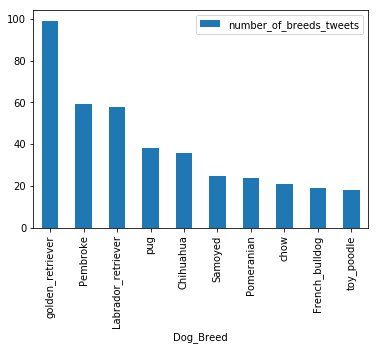

In [447]:
by_value_counts.plot(kind='bar')

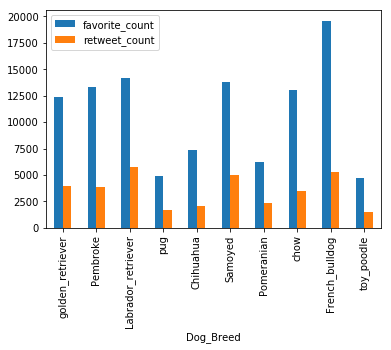

In [443]:
by_fav_and_retweet.plot(kind='bar')

* Visualization of month by month usage of hashtags, do identify is there are any noticable trends

### Code

In [348]:
df_dates_hashtags = df.groupby(['timestamp']).agg({'hashtags':'sum'})

df_dates_hashtags = df_dates_hashtags.groupby(pd.TimeGrouper("M")).agg({'hashtags':'sum'})
df_dates_hashtags = df_dates_hashtags[df_dates_hashtags['hashtags'].map(len) >=1]
df_dates_hashtags = df_dates_hashtags.groupby(df_dates_hashtags.index)['hashtags'].apply(lambda x: pd.DataFrame(x.iloc[0],columns=['hashtags'])).reset_index()
df_dates_hashtags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 3 columns):
timestamp    29 non-null datetime64[ns]
level_1      29 non-null int64
hashtags     29 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 768.0+ bytes


In [349]:
df_dates_hashtags

,timestamp,level_1,hashtags
0,2015-11-30,0,#NoDaysOff
1,2015-11-30,1,#swole
2,2016-01-31,0,#notallpuppers
3,2016-03-31,0,#LoveTwitter
4,2016-04-30,0,#FinalFur
5,2016-06-30,0,#BarkWeek
6,2016-06-30,1,#BarkWeek
7,2016-07-31,0,#BarkWeek
8,2016-11-30,0,#ImWithThor
9,2017-01-31,0,#WomensMarch


In [350]:
df_dates_hashtags =  df_dates_hashtags.groupby(['timestamp','hashtags'])['timestamp'].count().unstack('hashtags').fillna(0)
df_dates_hashtags

hashtags,#BATP,#BarkWeek,#BellLetsTalk,#Canada150,#FinalFur,#GoodDogs,#ImWithThor,#K9VeteransDay,#LoveTwitter,#NoDaysOff,#PrideMonth,#PrideMonthPuppo,#ScienceMarch,#WKCDogShow,#WomensMarch,#dogsatpollingstations,#notallpuppers,#swole
timestamp,,,,,,,,,,,,,,,,,,
2015-11-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


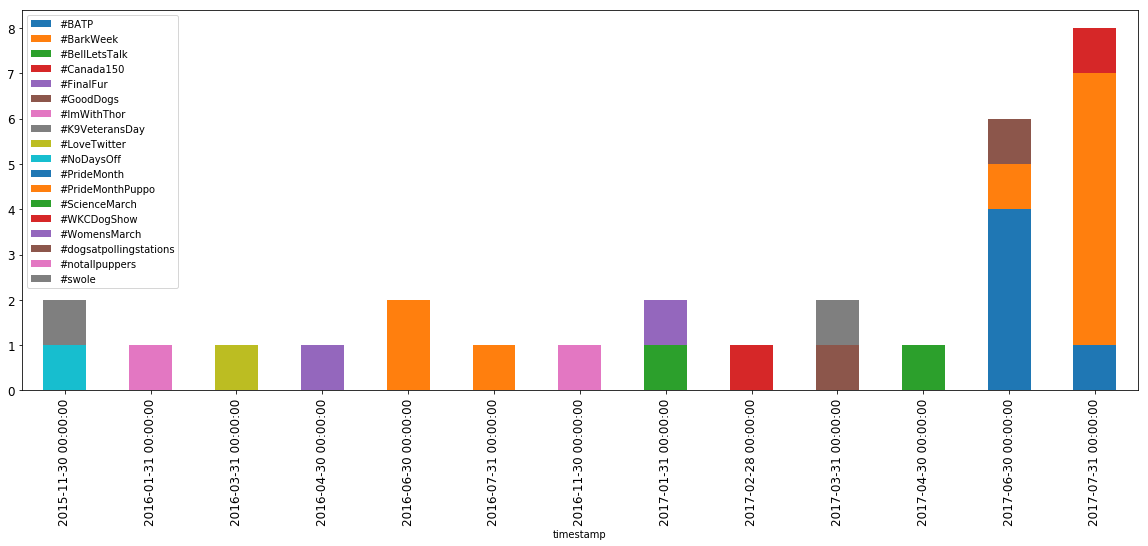

In [351]:
figsize=(15,20)
df_dates_hashtags.plot.bar(stacked=True, figsize=(20,7), fontsize = 12)
# plt.legend(bbox_to_anchor=(1,1))
plt.legend(loc=2)
plt.show()

In [449]:
df.to_csv('twitter_archive_master.csv',encoding = 'utf-8')
image_pred_top_10_counts_df.to_csv('top_10_breed_analysis.csv')
top_10_means.to_csv('top_10_breed_average_analysis.csv')

